In [88]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
with open('../names.txt', 'r') as file:
    names = file.read().split()

print('Total names:', len(names))
print(names[:5])

Total names: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [90]:
# Form stoi and itos
vocab = sorted(list(set(''.join(names))))
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

vocab_size = len(stoi)

In [91]:
block_size = 3
def form_dataset(words):
    X = []
    Y = []

    for word in words:
        word = ['.'] * block_size + list(word) + ['.']
        for ind in range(3, len(word)):
            X.append([stoi[x] for x in word[ind-3:ind]])
            Y.append(stoi[word[ind]])
            # print(''.join(word[ind-3:ind]), '--->', word[ind])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [92]:
import random
random.seed(42)
random.shuffle(names)

X, Y = form_dataset(names)

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0) # input is split into X[:n1], X[n1:n2] and X[n2:]
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)

g = torch.Generator().manual_seed(2147483647)

In [ ]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=g) / (in_features ** 0.5) # Glorot initialization
        self.bias = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        # forward pass        
        self.out = x @ self.weight
        if self.bias is not None:
            self.out = self.out + self.bias
        
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [220]:
layer = Linear(4, 6)
layer(torch.randn(100, 4))
layer.parameters()

[tensor([[-0.0667, -0.0067, -0.0840,  0.0416,  0.0311, -0.1286],
         [-0.0095, -0.0147, -0.0247, -0.0504,  0.0346,  0.0593],
         [-0.0548, -0.1376,  0.0457,  0.1021, -0.0722,  0.0204],
         [-0.0406,  0.1192,  0.1013,  0.0611,  0.1171, -0.0571]]),
 tensor([-0.5984,  0.1402,  0.5486, -0.1993,  1.9692, -2.0762])]

In [225]:
    class Tanh:
        def __call__(self, x):
            self.out = torch.tanh(x)
            return self.out
        def parameters(self):
            return []

In [181]:
th = Tanh()
th(torch.randn(10))

tensor([-0.2929, -0.8893,  0.9828, -0.8466,  0.8862, -0.4510,  0.9410,  0.3797,
         0.1459, -0.0227])

In [182]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        """
        dim: Dimensionality or num_features
        """
        self.dim = dim
        self.eps = eps
        self.momentum = momentum
        self.training = True # By default for training

        self.gamma = torch.ones(dim) # initialized to 1 for multiplication
        self.beta = torch.zeros(dim) # initialized to 0 for addition

        # track running stats is True by default
        self.running_mean = torch.zeros(dim)
        self.running_variance = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xstd = x.std(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xstd = self.running_variance

        xhat = (x - xmean) / torch.sqrt(xstd + self.eps)
        self.out =  self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad(): # context manager
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_variance = self.momentum * xstd + (1-self.momentum) * self.running_variance
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [265]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn(vocab_size, n_embd) # embedding matrix used to encode the dataset into vector space of 10

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # So that it is closer to 0 at the last layer and less confident in predictions
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # this gain is necessary to fight tanh which is squashing function between -1 & 1  

parameters = [C] + [p for layer in layers for p in layer.parameters()]
count = sum(p.nelement() for p in parameters)
print('Total parameters:', count)
for p in parameters:
	p.requires_grad = True

Total parameters: 46497


In [190]:
# Rough forward/backward pass
embs = C[Xtr].view(-1, block_size * n_embd)
for layer in layers:
    embs = layer(embs)

print(embs.shape)

loss = F.cross_entropy(embs, Ytr)
print(loss.item())

for p in parameters:
    p.grad = None

loss.backward()

for p in parameters:
    p.data += -0.1 * p.grad

torch.Size([182516, 27])
3.5872111320495605


In [266]:
max_steps = 1000
batch_size = 32
for step in range(max_steps):
    # mini batch construction
    batch_inds = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,))
    Xb, Yb = Xtr[batch_inds], Ytr[batch_inds]

    embs = C[Xb]
    x = embs.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)
    print(loss.item())

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    
    loss.backward()
    lr = 0.1 if step < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    break

print(loss.item())

3.288968563079834
3.288968563079834


tensor(0.0011, grad_fn=<MeanBackward0>)
layer 1 (      Tanh): mean +0.00, std 0.78, saturated: 24.34%
tensor(-0.0093, grad_fn=<MeanBackward0>)
layer 3 (      Tanh): mean -0.01, std 0.70, saturated: 10.62%
tensor(-0.0104, grad_fn=<MeanBackward0>)
layer 5 (      Tanh): mean -0.01, std 0.68, saturated: 7.50%
tensor(0.0050, grad_fn=<MeanBackward0>)
layer 7 (      Tanh): mean +0.00, std 0.66, saturated: 6.12%
tensor(-0.0054, grad_fn=<MeanBackward0>)
layer 9 (      Tanh): mean -0.01, std 0.65, saturated: 5.00%


Text(0.5, 1.0, 'activation distribution')

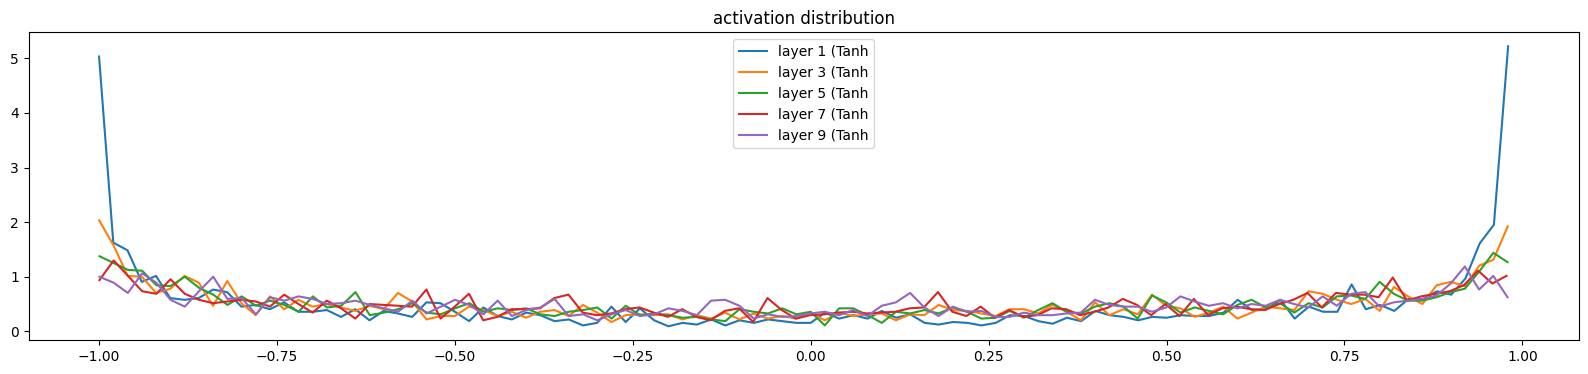

In [267]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print(t.mean())
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, 
          t.mean(), t.std(), 
          (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean +0.000000, std 3.870278e-04
layer 3 (      Tanh): mean +0.000007, std 3.688823e-04
layer 5 (      Tanh): mean +0.000010, std 3.522734e-04
layer 7 (      Tanh): mean +0.000004, std 3.278713e-04
layer 9 (      Tanh): mean -0.000003, std 3.019261e-04


Text(0.5, 1.0, 'gradient distribution')

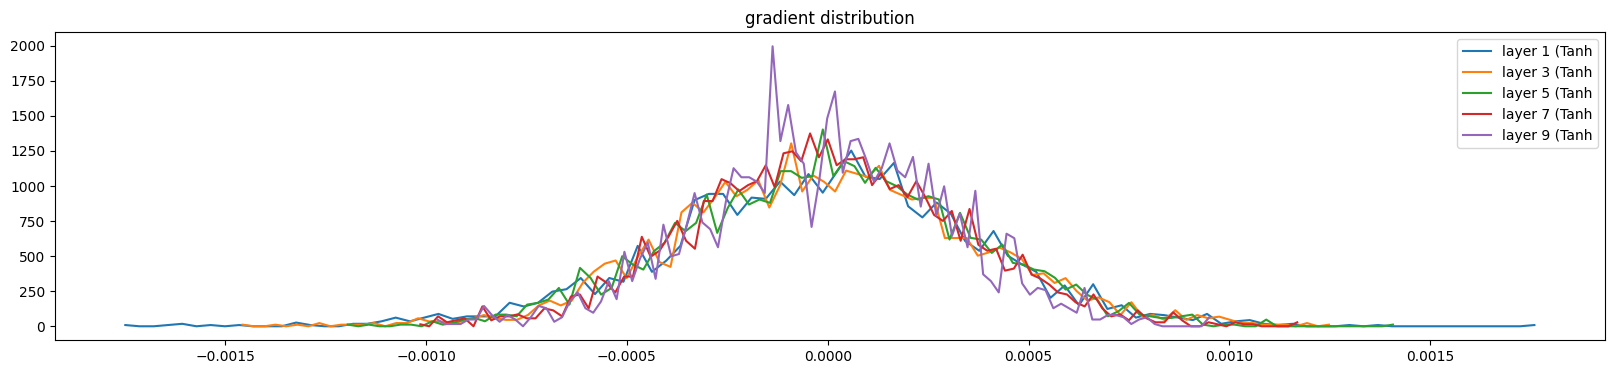

In [268]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000180 | std 1.092276e-03 | grad:data ratio 1.112732e-03
weight  (30, 100) | mean +0.000018 | std 1.179201e-03 | grad:data ratio 3.864969e-03
weight (100, 100) | mean +0.000004 | std 9.637281e-04 | grad:data ratio 5.701530e-03
weight (100, 100) | mean -0.000007 | std 8.421820e-04 | grad:data ratio 5.042187e-03
weight (100, 100) | mean +0.000003 | std 8.021523e-04 | grad:data ratio 4.756486e-03
weight (100, 100) | mean -0.000009 | std 7.607936e-04 | grad:data ratio 4.524368e-03
weight  (100, 27) | mean +0.000000 | std 2.191687e-02 | grad:data ratio 2.135598e+00


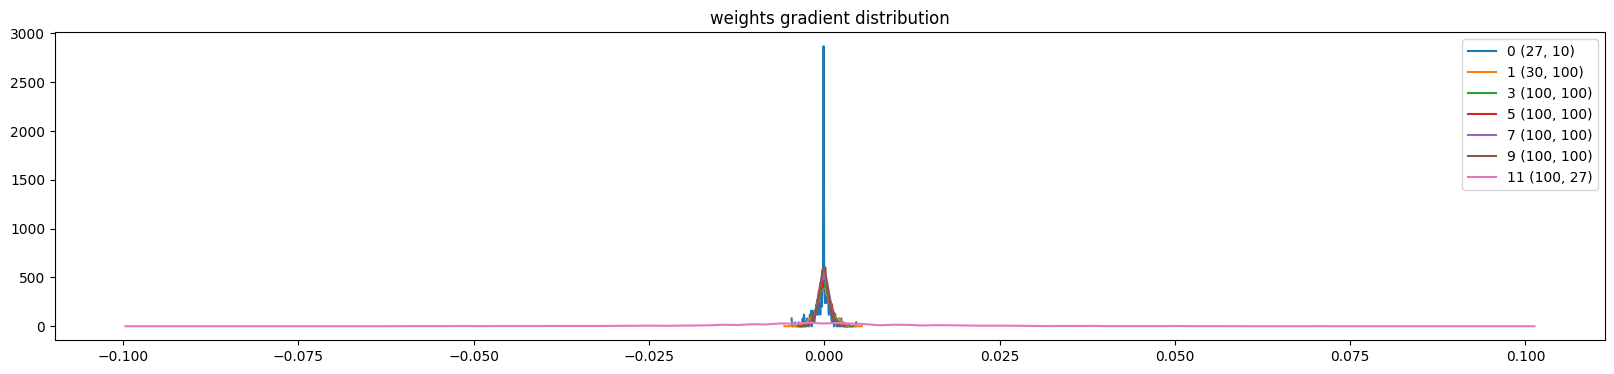

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # weights parameter only
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');